## Task 1:  Dependencies


In [248]:
from dotenv import load_dotenv

load_dotenv(dotenv_path=".env")

True

In [249]:
def check_if_env_var_is_set(env_var_name: str, human_readable_string: str = "API Key"):
    api_key = os.getenv(env_var_name)
  
    if api_key:
       print(f"{env_var_name} is present")
    else:
      print(f"{env_var_name} is NOT present, paste key at the prompt:")
      os.environ[env_var_name] = getpass.getpass(f"Please enter your {human_readable_string}: ")

## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [250]:
import os
import getpass

check_if_env_var_is_set("OPENAI_API_KEY", "OpenAI API key")
check_if_env_var_is_set("COHERE_API_KEY", "Cohere API key")
check_if_env_var_is_set("TAVILY_API_KEY", "TAVILY API key")

OPENAI_API_KEY is present
COHERE_API_KEY is present
TAVILY_API_KEY is present


In [251]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - Certification Challenge"
check_if_env_var_is_set("LANGCHAIN_API_KEY", "LangSmith API Key")

LANGCHAIN_API_KEY is present


In [252]:
import importlib
import graph_rag_functions
importlib.reload(graph_rag_functions)
from graph_rag_functions import naive_graph, contextual_compression_graph, multi_query_graph, parent_document_graph

from langchain_core.tools import tool

In [253]:
@tool
def ask_naive_llm_tool(question: str):
    """PRIMARY TOOL: Query comprehensive federal student loan policy documents using  specialized RAG retrieval.
      
      USE THIS FIRST for ALL student loan questions including:
      - Loan repayment plans and options
      - Forgiveness programs and eligibility
      - Payment problems and solutions
      - Application processes and requirements
      - Policy explanations and guidance
      
      This tool contains the most complete and up-to-date federal student loan information.
    """
    response = naive_graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

In [254]:
tavily_tool = TavilySearchResults(max_results=5)

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

model = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0,  # Lower temperature for more consistent outputs
    request_timeout=120,  # Longer timeout for complex operations
)

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state):
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "action"

    return END

tool_belt = [
    ask_naive_llm_tool,
    tavily_tool,
    Tool(
        name="StudentAid_Federal_Search",
        description="Search ONLY StudentAid.gov for official federal information: FAFSA applications, federal loan forgiveness programs, federal repayment plans, eligibility requirements",
        func=tavily_studentaid_search,
    ),
    Tool(
        name="Mohela_Servicer_Search",
        description="Search ONLY Mohela loan servicer for account-specific help: making payments, login issues, servicer-specific repayment options, customer service contacts",
        func=tavily_mohela_search,
    ),
    Tool(
        name="Student_Loan_Comparison_Search",
        description="Compare information across BOTH federal sources and Mohela when user needs comprehensive view or comparison of student loan options",
        func=tavily_student_loan_search,
    ),
]

model = model.bind_tools(tool_belt)
tool_node = ToolNode(tool_belt)

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

uncompiled_graph.set_entry_point("agent")
uncompiled_graph.add_conditional_edges("agent", should_continue)

uncompiled_graph.add_edge("action", "agent")

naive_agent_graph = uncompiled_graph.compile()

In [296]:
import tool_calls_parser_for_eval
importlib.reload(tool_calls_parser_for_eval)
from tool_calls_parser_for_eval import parse_logs, print_formatted_results, extract_contexts_for_eval, parse_langchain_messages

In [297]:
from langchain_core.messages import HumanMessage

# inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}
# inputs = {"messages" : [HumanMessage(content="What concerns does the borrower have regarding Nelnet's communication about their student loan issuer?")]}
inputs = {"messages" : [HumanMessage(content="What is the issue with Aidvantage in the borrower's complaint?")]}

async for chunk in naive_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
          print_formatted_results(parse_logs(str(values["messages"])))
        print("\n")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'


[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MBqG1ua36y77NG7NMb8m3ssd', 'function': {'arguments': '{"__arg1":"Aidvantage borrower complaint"}', 'name': 'StudentAid_Federal_Search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 340, 'total_tokens': 363, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-C01TquQua7zq4OMuHSZVoHsb7P5ZU', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ba6a81b8-379a-4259-891f-05cbfa3d8cb6-0', tool_calls=[{'name': 'StudentAid_Federal_Search', 'args': {'__arg1': 'Aidvantage borrower complaint'}, 'id': 'call_MBqG1ua36y77NG7NMb8m3ssd', 'type': '

In [298]:
# inputs = {"messages" : [HumanMessage(content='')]}
response = naive_agent_graph.invoke(inputs)

evaluation_contexts = extract_contexts_for_eval(response["messages"])
print(f"✅ Extracted {len(evaluation_contexts)} contexts for evaluation")
parsed_data = parse_langchain_messages(response["messages"])
print_formatted_results(parsed_data)

eval_sample = {
    "user_input": inputs["messages"][0].content,
    "response": response["messages"][-1].content,  # Final AI response
    "retrieved_contexts": evaluation_contexts,
    "tools_used": parsed_data['summary']['tools'],
    "num_contexts": len(evaluation_contexts)
}

print(f"\n🎯 EVALUATION SAMPLE:")
print(f"Query: {eval_sample['user_input']}")
print(f"Response: {eval_sample['response'][:200]}...")
print(f"Contexts: {eval_sample['num_contexts']} extracted")
print(f"Tools: {eval_sample['tools_used']}")

✅ Extracted 5 contexts for evaluation
=== PARSING RESULTS ===
Tool calls: 1
Tool results: 3
Tools used: [None, 'StudentAid_Federal_Search']

=== TOOL CALLS ===
1. StudentAid_Federal_Search -> {'__arg1': 'Aidvantage borrower complaint'}

=== TOOL RESULTS ===
1. None -> What is the issue with Aidvantage in the borrower's complaint?...
2. StudentAid_Federal_Search -> StudentAid.gov Search Results for: Aidvantage borrower complaint  Summary: Aidvantage handles federa...
3. None -> The issue with Aidvantage in the borrower's complaint is not explicitly detailed in the search resul...

=== CONTEXT EXTRACTION DEMO ===
Extracted 5 contexts for evaluation:
1. StudentAid.gov Search Results for: Aidvantage borrower complaint...
2. Summary: Aidvantage handles federal student loan servicing; borrowers can submit complaints via the Help Center. Aidvantage is a private company manag...
3. Official Federal Information:
1. Aidvantage
   Aidvantage is an official student loan servicer of Federal Student

### Generate Golden master

In [258]:
import importlib
import core_functions
importlib.reload(core_functions)

from core_functions import load_and_prepare_pdf_loan_docs, load_and_prepare_csv_loan_docs, generate_golden_master

OPENAI_API_KEY is present
COHERE_API_KEY is present


In [259]:
%%time
student_loan_pdf_docs_dataset = load_and_prepare_pdf_loan_docs()
student_loan_complaint_docs_dataset  = load_and_prepare_csv_loan_docs()
student_loan_docs_dataset = student_loan_pdf_docs_dataset + student_loan_complaint_docs_dataset

CPU times: user 1.01 s, sys: 15.3 ms, total: 1.03 s
Wall time: 1.04 s


In [260]:
%%time
golden_master_dataset = generate_golden_master(student_loan_docs_dataset)

CPU times: user 110 ms, sys: 826 μs, total: 111 ms
Wall time: 115 ms


In [261]:
golden_master_dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How does the structure of an academic calendar...,"[non-term (includes clock-hour calendars), or ...",The structure of an academic calendar—whether ...,single_hop_specifc_query_synthesizer
1,"medicine program clinical work, it gotta be in...",[Inclusion of Clinical Work in a Standard Term...,If the clinical work in a medicine program mee...,single_hop_specifc_query_synthesizer
2,Wen do Title IV program disbursements need to ...,[Non-Term Characteristics A program that measu...,"Title IV program disbursements, except for Fed...",single_hop_specifc_query_synthesizer
3,so like if a student gettin a TEACH Grant in a...,[both the credit or clock hours and the weeks ...,if a student gettin a TEACH Grant in a clock-h...,single_hop_specifc_query_synthesizer
4,How does the disbursement timing for federal s...,[<1-hop>\n\nboth the credit or clock hours and...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
5,How do the disbursement timing requirements fo...,[<1-hop>\n\nboth the credit or clock hours and...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
6,If a practicum or clinical experience is requi...,[<1-hop>\n\nInclusion of Clinical Work in a St...,A practicum or clinical experience required fo...,multi_hop_abstract_query_synthesizer
7,How do the disbursement timing requirements fo...,[<1-hop>\n\nboth the credit or clock hours and...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
8,"Acccording to Volume 8, Chapter 3, how does th...",[<1-hop>\n\nInclusion of Clinical Work in a St...,"Volume 8, Chapter 3 explains that clinical wor...",multi_hop_specific_query_synthesizer
9,how do appendix a and appendix b help schools ...,[<1-hop>\n\nboth the credit or clock hours and...,appendix a gives examples that illustrate the ...,multi_hop_specific_query_synthesizer


In [262]:
from ragas import EvaluationDataset

from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.cost import get_token_usage_for_openai

from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig
from ragas_metrics import extract_ragas_metrics

### Synthetic Data Generation using RAGAS using the Golden master (Naive Retriever)

In [263]:
%%time
from tqdm.notebook import tqdm
for test_row in tqdm(golden_master_dataset):
    inputs = {"messages" : [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = naive_agent_graph.invoke(inputs)

    evaluation_contexts = extract_contexts_for_eval(response["messages"])
    eval_sample = {
        "user_input": inputs["messages"][0].content,
        "response": response["messages"][-1].content,  # Final AI response
        "retrieved_contexts": evaluation_contexts,
        "tools_used": parsed_data['summary']['tools'],
        "num_contexts": len(evaluation_contexts)
    }
    test_row.eval_sample.response = eval_sample["response"]
    test_row.eval_sample.retrieved_contexts = eval_sample["retrieved_contexts"]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 5.59 s, sys: 130 ms, total: 5.72 s
Wall time: 1min 14s


In [264]:
golden_master_dataset.to_pandas().to_csv('golden-masters/naive_golden_master_dataset.csv', index=False)
golden_master_dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How does the structure of an academic calendar...,[StudentAid.gov Search Results for: Pell Grant...,"[non-term (includes clock-hour calendars), or ...","The structure of an academic calendar, such as...",The structure of an academic calendar—whether ...,single_hop_specifc_query_synthesizer
1,"medicine program clinical work, it gotta be in...",[],[Inclusion of Clinical Work in a Standard Term...,Could you please clarify your question a bit m...,If the clinical work in a medicine program mee...,single_hop_specifc_query_synthesizer
2,Wen do Title IV program disbursements need to ...,[],[Non-Term Characteristics A program that measu...,"For non-term programs, Title IV program disbur...","Title IV program disbursements, except for Fed...",single_hop_specifc_query_synthesizer
3,so like if a student gettin a TEACH Grant in a...,[],[both the credit or clock hours and the weeks ...,If a student receiving a TEACH Grant in a cloc...,if a student gettin a TEACH Grant in a clock-h...,single_hop_specifc_query_synthesizer
4,How does the disbursement timing for federal s...,[],[<1-hop>\n\nboth the credit or clock hours and...,In clock-hour or non-term credit-hour programs...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
5,How do the disbursement timing requirements fo...,[],[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
6,If a practicum or clinical experience is requi...,[],[<1-hop>\n\nInclusion of Clinical Work in a St...,A practicum or clinical experience required fo...,A practicum or clinical experience required fo...,multi_hop_abstract_query_synthesizer
7,How do the disbursement timing requirements fo...,[],[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
8,"Acccording to Volume 8, Chapter 3, how does th...",[],[<1-hop>\n\nInclusion of Clinical Work in a St...,"According to Volume 8, Chapter 3, the inclusio...","Volume 8, Chapter 3 explains that clinical wor...",multi_hop_specific_query_synthesizer
9,how do appendix a and appendix b help schools ...,[],[<1-hop>\n\nboth the credit or clock hours and...,Appendix A and Appendix B provide detailed gui...,appendix a gives examples that illustrate the ...,multi_hop_specific_query_synthesizer


In [265]:
# golden_master_dataset.to_pandas()[10:11]['retrieved_contexts'].values[0]

In [266]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [267]:
%%time
evaluation_dataset = EvaluationDataset.from_pandas(golden_master_dataset.to_pandas())

evaluator_llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0, # Lower temperature for more consistent outputs
        request_timeout=120   # Longer timeout for complex operations
    )
)

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), 
             ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    token_usage_parser=get_token_usage_for_openai,
    run_config=custom_run_config
)

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[11]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[17]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[23]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[41]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[29]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[53]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[47]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[35]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[59]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception 

CPU times: user 6.57 s, sys: 1 s, total: 7.57 s
Wall time: 2h 52min 43s


In [268]:
import pandas as pd
naive_raw_stats_df = pd.DataFrame([extract_ragas_metrics(result, 'gpt-4.1-mini')])
record_metrics_from_run('Naive', naive_raw_stats_df)

In [269]:
import os
from datetime import datetime
def record_metrics_from_run(retriever_name, dataframe: pd.DataFrame):
    new_dataframe = dataframe.copy()
    columns=['context_recall', 'faithfulness', 'factual_correctness', 'answer_relevancy', 'context_entity_recall', 'noise_sensitivity_relevant']
    metrics_filename = 'ragas-evaluation-metrics.csv'
    dataset_df = pd.DataFrame()
    if os.path.exists(metrics_filename):
        dataset_df = pd.read_csv(metrics_filename)
    new_dataframe['datetime'] = datetime.now().strftime('%Y-%m-%d %T')
    new_dataframe['retriever'] = retriever_name
    new_dataframe = new_dataframe[['datetime', 'retriever'] + columns]
    dataset_df = pd.concat([dataset_df, new_dataframe])

    dataset_df.to_csv(metrics_filename, index=False)

### Synthetic Data Generation using RAGAS using the Golden master (Contextual Compression Retriever)

In [270]:
@tool
def ask_contextual_compression_llm_tool(question: str):
    """PRIMARY TOOL: Query comprehensive federal student loan policy documents using  specialized RAG retrieval.
      
      USE THIS FIRST for ALL student loan questions including:
      - Loan repayment plans and options
      - Forgiveness programs and eligibility
      - Payment problems and solutions
      - Application processes and requirements
      - Policy explanations and guidance
      
      This tool contains the most complete and up-to-date federal student loan information.
    """
    response = contextual_compression_graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }
model = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0,  # Lower temperature for more consistent outputs
    request_timeout=120,  # Longer timeout for complex operations
)

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state):
    last_message = state["messages"][-1]

    if last_message.tool_calls:
        return "action"

    return END

tool_belt = [
    ask_contextual_compression_llm_tool,
    tavily_tool,
    Tool(
        name="StudentAid_Federal_Search",
        description="Search ONLY StudentAid.gov for official federal information: FAFSA applications, federal loan forgiveness programs, federal repayment plans, eligibility requirements",
        func=tavily_studentaid_search,
    ),
    Tool(
        name="Mohela_Servicer_Search",
        description="Search ONLY Mohela loan servicer for account-specific help: making payments, login issues, servicer-specific repayment options, customer service contacts",
        func=tavily_mohela_search,
    ),
    Tool(
        name="Student_Loan_Comparison_Search",
        description="Compare information across BOTH federal sources and Mohela when user needs comprehensive view or comparison of student loan options",
        func=tavily_student_loan_search,
    ),
]

model = model.bind_tools(tool_belt)
tool_node = ToolNode(tool_belt)

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

uncompiled_graph.set_entry_point("agent")
uncompiled_graph.add_conditional_edges("agent", should_continue)

uncompiled_graph.add_edge("action", "agent")

contextual_compression_agent_graph = uncompiled_graph.compile()

In [271]:
import copy
import time
cc_golden_master_dataset = copy.deepcopy(golden_master_dataset)

In [272]:
# inputs = {"messages" : [HumanMessage(content="What concerns does the borrower have regarding Nelnet's communication about their student loan issuer?")]}
# response = simple_agent_graph.invoke(inputs)
# response

In [273]:
%%time
from tqdm.notebook import tqdm
for test_row in tqdm(cc_golden_master_dataset):
    inputs = {"messages" : [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = contextual_compression_agent_graph.invoke(inputs)

    evaluation_contexts = extract_contexts_for_eval(response["messages"])
    eval_sample = {
        "user_input": inputs["messages"][0].content,
        "response": response["messages"][-1].content,  # Final AI response
        "retrieved_contexts": evaluation_contexts,
        "tools_used": parsed_data['summary']['tools'],
        "num_contexts": len(evaluation_contexts)
    }
    test_row.eval_sample.response = eval_sample["response"]
    test_row.eval_sample.retrieved_contexts = eval_sample["retrieved_contexts"]
    time.sleep(2)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 5.23 s, sys: 238 ms, total: 5.47 s
Wall time: 1min 44s


In [274]:
cc_golden_master_dataset.to_pandas().to_csv('golden-masters/cc_golden_master_dataset.csv', index=False)
cc_golden_master_dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How does the structure of an academic calendar...,[StudentAid.gov Search Results for: Pell Grant...,"[non-term (includes clock-hour calendars), or ...",The disbursement of Pell Grants is generally b...,The structure of an academic calendar—whether ...,single_hop_specifc_query_synthesizer
1,"medicine program clinical work, it gotta be in...",[],[Inclusion of Clinical Work in a Standard Term...,Could you please clarify your question a bit m...,If the clinical work in a medicine program mee...,single_hop_specifc_query_synthesizer
2,Wen do Title IV program disbursements need to ...,[],[Non-Term Characteristics A program that measu...,"For non-term programs, Title IV program disbur...","Title IV program disbursements, except for Fed...",single_hop_specifc_query_synthesizer
3,so like if a student gettin a TEACH Grant in a...,[],[both the credit or clock hours and the weeks ...,Exceeding the scheduled weeks or hours in a pa...,if a student gettin a TEACH Grant in a clock-h...,single_hop_specifc_query_synthesizer
4,How does the disbursement timing for federal s...,[],[<1-hop>\n\nboth the credit or clock hours and...,In clock-hour or non-term credit-hour programs...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
5,How do the disbursement timing requirements fo...,[StudentAid.gov Search Results for: disburseme...,[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
6,If a practicum or clinical experience is requi...,[],[<1-hop>\n\nInclusion of Clinical Work in a St...,A practicum or clinical experience required fo...,A practicum or clinical experience required fo...,multi_hop_abstract_query_synthesizer
7,How do the disbursement timing requirements fo...,[StudentAid.gov Search Results for: disburseme...,[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
8,"Acccording to Volume 8, Chapter 3, how does th...",[],[<1-hop>\n\nInclusion of Clinical Work in a St...,"According to Volume 8, Chapter 3, the inclusio...","Volume 8, Chapter 3 explains that clinical wor...",multi_hop_specific_query_synthesizer
9,how do appendix a and appendix b help schools ...,[],[<1-hop>\n\nboth the credit or clock hours and...,Appendix A and Appendix B provide detailed gui...,appendix a gives examples that illustrate the ...,multi_hop_specific_query_synthesizer


In [275]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [276]:
%%time
cc_evaluation_dataset = EvaluationDataset.from_pandas(cc_golden_master_dataset.to_pandas())

evaluator_llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0, # Lower temperature for more consistent outputs
        request_timeout=120   # Longer timeout for complex operations
    )
)

custom_run_config = RunConfig(timeout=360)

cc_result = evaluate(
    dataset=cc_evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), 
             ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    token_usage_parser=get_token_usage_for_openai,
    run_config=custom_run_config
)

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[11]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[17]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[23]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[29]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[41]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[53]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[59]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[71]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[65]: ValueError(zero-size array to reduction operation maximum which has no identity)


CPU times: user 6.84 s, sys: 969 ms, total: 7.81 s
Wall time: 5min 6s


In [277]:
cc_raw_stats_df = pd.DataFrame([extract_ragas_metrics(cc_result, 'gpt-4.1-mini')])
record_metrics_from_run('Contextual Compression', cc_raw_stats_df)

### Synthetic Data Generation using RAGAS using the Golden master (Multi Query Retriver)

In [286]:
@tool
def ask_multi_query_llm_tool(question: str):
    """PRIMARY TOOL: Query comprehensive federal student loan policy documents using specialized RAG retrieval.
      
      USE THIS FIRST for ALL student loan questions including:
      - Loan repayment plans and options
      - Forgiveness programs and eligibility
      - Payment problems and solutions
      - Application processes and requirements
      - Policy explanations and guidance
      
      This tool contains the most complete and up-to-date federal student loan information.
    """
    response = multi_query_graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }
multi_query_agent_graph = get_agent_graph([ask_multi_query_llm_tool])

In [287]:
import copy
import time
mq_golden_master_dataset = copy.deepcopy(golden_master_dataset)

In [288]:
%%time
from tqdm.notebook import tqdm

for test_row in tqdm(mq_golden_master_dataset):
    inputs = {"messages" : [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = multi_query_agent_graph.invoke(inputs)

    evaluation_contexts = extract_contexts_for_eval(response["messages"])
    eval_sample = {
        "user_input": inputs["messages"][0].content,
        "response": response["messages"][-1].content,  # Final AI response
        "retrieved_contexts": evaluation_contexts,
        "tools_used": parsed_data['summary']['tools'],
        "num_contexts": len(evaluation_contexts)
    }
    test_row.eval_sample.response = eval_sample["response"]
    test_row.eval_sample.retrieved_contexts = eval_sample["retrieved_contexts"]
    time.sleep(2)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 13.2 s, sys: 200 ms, total: 13.4 s
Wall time: 2min 17s


In [289]:
mq_golden_master_dataset.to_pandas().to_csv('golden-masters/mq_golden_master_dataset.csv', index=False)
mq_golden_master_dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How does the structure of an academic calendar...,[StudentAid.gov Search Results for: Pell Grant...,"[non-term (includes clock-hour calendars), or ...","The structure of an academic calendar, such as...",The structure of an academic calendar—whether ...,single_hop_specifc_query_synthesizer
1,"medicine program clinical work, it gotta be in...",[],[Inclusion of Clinical Work in a Standard Term...,Could you please clarify your question a bit m...,If the clinical work in a medicine program mee...,single_hop_specifc_query_synthesizer
2,Wen do Title IV program disbursements need to ...,[],[Non-Term Characteristics A program that measu...,"For non-term programs, Title IV program disbur...","Title IV program disbursements, except for Fed...",single_hop_specifc_query_synthesizer
3,so like if a student gettin a TEACH Grant in a...,[],[both the credit or clock hours and the weeks ...,If a student receiving a TEACH Grant in a cloc...,if a student gettin a TEACH Grant in a clock-h...,single_hop_specifc_query_synthesizer
4,How does the disbursement timing for federal s...,[StudentAid.gov Search Results for: disburseme...,[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing for federal student ai...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
5,How do the disbursement timing requirements fo...,[],[<1-hop>\n\nboth the credit or clock hours and...,In clock-hour or non-term credit-hour programs...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
6,If a practicum or clinical experience is requi...,[],[<1-hop>\n\nInclusion of Clinical Work in a St...,A practicum or clinical experience required fo...,A practicum or clinical experience required fo...,multi_hop_abstract_query_synthesizer
7,How do the disbursement timing requirements fo...,[],[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
8,"Acccording to Volume 8, Chapter 3, how does th...",[],[<1-hop>\n\nInclusion of Clinical Work in a St...,"According to Volume 8, Chapter 3, the inclusio...","Volume 8, Chapter 3 explains that clinical wor...",multi_hop_specific_query_synthesizer
9,how do appendix a and appendix b help schools ...,[],[<1-hop>\n\nboth the credit or clock hours and...,Appendix A and Appendix B provide detailed gui...,appendix a gives examples that illustrate the ...,multi_hop_specific_query_synthesizer


In [290]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [291]:
%%time
mq_evaluation_dataset = EvaluationDataset.from_pandas(mq_golden_master_dataset.to_pandas())

evaluator_llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0, # Lower temperature for more consistent outputs
        request_timeout=120   # Longer timeout for complex operations
    )
)

custom_run_config = RunConfig(timeout=360)

mq_result = evaluate(
    dataset=mq_evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), 
             ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    token_usage_parser=get_token_usage_for_openai,
    run_config=custom_run_config
)

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[11]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[17]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[23]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[35]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[41]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[53]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[47]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[59]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[65]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception 

CPU times: user 7.38 s, sys: 919 ms, total: 8.3 s
Wall time: 6min 15s


In [292]:
mq_raw_stats_df = pd.DataFrame([extract_ragas_metrics(mq_result, 'gpt-4.1-mini')])
record_metrics_from_run('MultiQuery', mq_raw_stats_df)

In [ ]:
import build_agent_graph
importlib.reload(build_agent_graph)

from build_agent_graph import get_agent_graph

In [299]:
@tool
def ask_parent_document_llm_tool(question: str):
    """PRIMARY TOOL: Query comprehensive federal student loan policy documents using  specialized RAG retrieval.
      
      USE THIS FIRST for ALL student loan questions including:
      - Loan repayment plans and options
      - Forgiveness programs and eligibility
      - Payment problems and solutions
      - Application processes and requirements
      - Policy explanations and guidance
      
      This tool contains the most complete and up-to-date federal student loan information.
    """
    response = parent_document_graph.invoke({"question": question})
    return {
        "messages": [HumanMessage(content=response["response"])],
        "context": response["context"]
    }

parent_document_graph_agent = get_agent_graph([ask_parent_document_llm_tool])

In [300]:
%%time
pd_golden_master_dataset = copy.deepcopy(golden_master_dataset)
from tqdm.notebook import tqdm
for test_row in tqdm(pd_golden_master_dataset):
    inputs = {"messages" : [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = parent_document_graph_agent.invoke(inputs)

    evaluation_contexts = extract_contexts_for_eval(response["messages"])
    eval_sample = {
        "user_input": inputs["messages"][0].content,
        "response": response["messages"][-1].content,  # Final AI response
        "retrieved_contexts": evaluation_contexts,
        "tools_used": parsed_data['summary']['tools'],
        "num_contexts": len(evaluation_contexts)
    }
    test_row.eval_sample.response = eval_sample["response"]
    test_row.eval_sample.retrieved_contexts = eval_sample["retrieved_contexts"]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 6.11 s, sys: 169 ms, total: 6.28 s
Wall time: 2min 38s


In [301]:
pd_golden_master_dataset.to_pandas().to_csv('golden-masters/pd_golden_master_dataset.csv', index=False)
pd_golden_master_dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How does the structure of an academic calendar...,"[non-term (includes clock-hour calendars), or\...","[non-term (includes clock-hour calendars), or ...",The structure of an academic calendar—such as ...,The structure of an academic calendar—whether ...,single_hop_specifc_query_synthesizer
1,"medicine program clinical work, it gotta be in...",[],[Inclusion of Clinical Work in a Standard Term...,Could you please clarify your question a bit m...,If the clinical work in a medicine program mee...,single_hop_specifc_query_synthesizer
2,Wen do Title IV program disbursements need to ...,"[hour, or non-SE9W nonstandard term program is...",[Non-Term Characteristics A program that measu...,Title IV program disbursements for non-term pr...,"Title IV program disbursements, except for Fed...",single_hop_specifc_query_synthesizer
3,so like if a student gettin a TEACH Grant in a...,[both the credit or clock hours and the weeks ...,[both the credit or clock hours and the weeks ...,Exceeding scheduled weeks or hours in a paymen...,if a student gettin a TEACH Grant in a clock-h...,single_hop_specifc_query_synthesizer
4,How does the disbursement timing for federal s...,[both the credit or clock hours and the weeks ...,[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing for federal student ai...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
5,How do the disbursement timing requirements fo...,[both the credit or clock hours and the weeks ...,[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
6,If a practicum or clinical experience is requi...,[Inclusion of Clinical Work in a Standard Term...,[<1-hop>\n\nInclusion of Clinical Work in a St...,Clinical or practicum experiences required for...,A practicum or clinical experience required fo...,multi_hop_abstract_query_synthesizer
7,How do the disbursement timing requirements fo...,[both the credit or clock hours and the weeks ...,[<1-hop>\n\nboth the credit or clock hours and...,The disbursement timing requirements for feder...,In clock-hour or non-term credit-hour programs...,multi_hop_abstract_query_synthesizer
8,"Acccording to Volume 8, Chapter 3, how does th...",[may not notify the school or the loan service...,[<1-hop>\n\nInclusion of Clinical Work in a St...,"According to Volume 8, Chapter 3, the inclusio...","Volume 8, Chapter 3 explains that clinical wor...",multi_hop_specific_query_synthesizer
9,how do appendix a and appendix b help schools ...,[year/program less than an\nacademic year; and...,[<1-hop>\n\nboth the credit or clock hours and...,Appendix A and Appendix B provide detailed gui...,appendix a gives examples that illustrate the ...,multi_hop_specific_query_synthesizer


In [302]:
%%time
pd_evaluation_dataset = EvaluationDataset.from_pandas(pd_golden_master_dataset.to_pandas())

evaluator_llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4.1-mini",
        temperature=0, # Lower temperature for more consistent outputs
        request_timeout=120   # Longer timeout for complex operations
    )
)

custom_run_config = RunConfig(timeout=360)

pd_result = evaluate(
    dataset=pd_evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), 
             ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    token_usage_parser=get_token_usage_for_openai,
    run_config=custom_run_config
)

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[11]: ValueError(zero-size array to reduction operation maximum which has no identity)
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[47]: TimeoutError()


CPU times: user 9.29 s, sys: 1.37 s, total: 10.7 s
Wall time: 7min 50s


In [303]:
pd_raw_stats_df = pd.DataFrame([extract_ragas_metrics(pd_result, 'gpt-4.1-mini')])
record_metrics_from_run('Parent Document', pd_raw_stats_df)

In [304]:
collected_df = pd.read_csv('ragas-evaluation-metrics.csv')
collected_df

,datetime,retriever,context_recall,faithfulness,factual_correctness,answer_relevancy,context_entity_recall,noise_sensitivity_relevant
0,2025-08-02 02:04:48,Naive,0.350694,0.613633,0.415833,0.549343,0.248621,0.153720
1,2025-08-02 02:06:59,Naive,0.238095,0.582634,0.372500,0.545608,0.166618,0.144066
2,2025-08-02 02:16:40,Contextual Compression,0.332837,0.607332,0.399167,0.555507,0.183947,0.178819
3,2025-08-02 02:18:48,Contextual Compression,0.236111,0.523480,0.371667,0.780958,0.127679,0.258818
4,2025-08-02 02:20:57,MultiQuery,0.150794,0.358812,0.283333,0.314659,0.094969,0.000000
5,2025-08-02 02:35:38,MultiQuery,0.154762,0.353284,0.380000,0.234008,0.081878,0.110624
6,2025-08-02 02:54:31,Parent Document,0.134425,0.371834,0.312500,0.310042,0.085646,0.052857
7,2025-08-02 04:37:46,Parent Document,0.668651,0.852142,0.645000,0.867385,0.466285,0.379090
8,2025-08-02 07:36:16,Naive,0.041667,0.044872,0.520833,0.862259,0.008333,0.000000
9,2025-08-02 07:43:07,Contextual Compression,0.076389,0.087037,0.519167,0.860121,0.020635,0.000000


/home/AIE7-Cert-Challenge/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


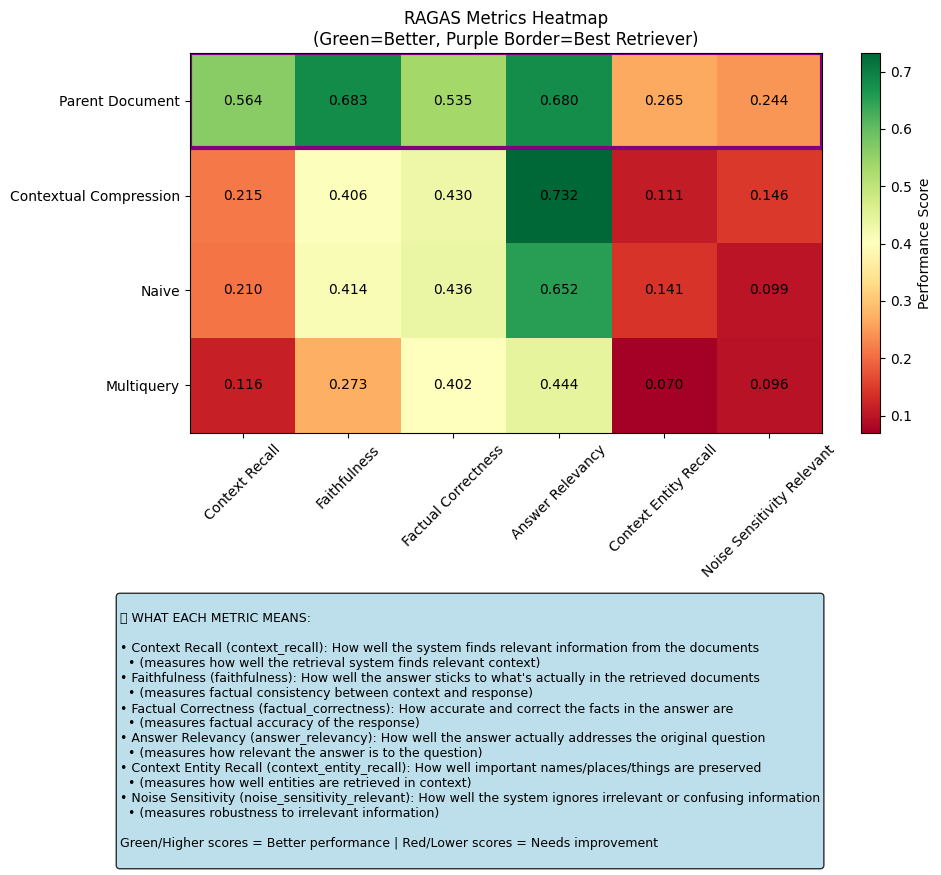

<module 'visualize_retriever_performance' from '/home/AIE7-Cert-Challenge/visualize_retriever_performance.py'>

In [313]:
import visualize_retriever_performance
importlib.reload(visualize_retriever_performance)